In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# =========================
# 0) Install deps
# =========================
!pip -q install gdown rasterio tifffile

import os
import random
from dataclasses import dataclass
from typing import List, Tuple, Optional

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import rasterio # для чтения окнами из больших TIFF
from rasterio.windows import Window

import tifffile as tiff
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display
from contextlib import nullcontext
from torch.cuda.amp import autocast as cuda_autocast

In [2]:
from torch.cuda.amp import autocast, GradScaler

In [3]:
# =========================
# 1) Download + unzip
# =========================

GDRIVE_URL = "https://drive.google.com/file/d/1f2pChGHdZ24yb-CFrAAbF8KbS3Ix35Du/view?"
OUT_ZIP = "/content/dataset.zip"
OUT_DIR = "/content/dataset"

!gdown --fuzzy "{GDRIVE_URL}" -O "{OUT_ZIP}"
!mkdir -p "{OUT_DIR}"
!unzip -q "{OUT_ZIP}" -d "{OUT_DIR}"

Downloading...
From (original): https://drive.google.com/uc?id=1f2pChGHdZ24yb-CFrAAbF8KbS3Ix35Du
From (redirected): https://drive.google.com/uc?id=1f2pChGHdZ24yb-CFrAAbF8KbS3Ix35Du&confirm=t&uuid=9652608f-5729-4b3a-b0e6-0fa5473ef416
To: /content/dataset.zip
100% 11.0G/11.0G [00:53<00:00, 205MB/s]


In [4]:
# =========================
# 2) Dataset
# =========================
IMG_EXTS = {".tif"}

def list_pairs_simple(root: str) -> List[Tuple[str, str]]:
    img_dir = os.path.join(root, "images")
    gt_dir  = os.path.join(root, "gt")
    pairs = []

    for fn in sorted(os.listdir(img_dir)):
        if os.path.splitext(fn.lower())[1] not in IMG_EXTS:
            continue
        img_path = os.path.join(img_dir, fn)
        gt_path  = os.path.join(gt_dir, fn)
        if not os.path.exists(gt_path):
            raise FileNotFoundError(f"Missing mask for {fn}: {gt_path}")
        pairs.append((img_path, gt_path))

    if not pairs:
        raise RuntimeError("No pairs found.")
    return pairs


def split_by_scene(pairs, val_ratio=0.15, seed=42):
    rng = random.Random(seed)
    idxs = list(range(len(pairs)))
    rng.shuffle(idxs)
    n_val = max(1, int(len(pairs) * val_ratio))
    val = set(idxs[:n_val])
    train_pairs = [p for i, p in enumerate(pairs) if i not in val]
    val_pairs   = [p for i, p in enumerate(pairs) if i in val]
    return train_pairs, val_pairs


def to_float01_hwc(img_hwc: np.ndarray) -> np.ndarray:
    # для RGB uint8/uint16
    if img_hwc.dtype == np.uint8:
        return img_hwc.astype(np.float32) / 255.0
    if img_hwc.dtype == np.uint16:
        return img_hwc.astype(np.float32) / 65535.0
    img = img_hwc.astype(np.float32)
    mx = np.nanmax(img)
    if mx > 1.5:
        img = img / (mx + 1e-6)
    return img


@dataclass
class CropConfig:
    patch_size: int = 256
    scale_jitter: Optional[Tuple[float, float]] = (0.75, 1.5)  # None for val
    augment: bool = True


class SatBuildingsDataset(Dataset):
    def __init__(
        self,
        root: str,
        split: str = "train",
        val_ratio: float = 0.15,
        seed: int = 42,
        samples_per_epoch: int = 4000,
        crop: CropConfig = CropConfig(),
    ):
        assert split in ("train", "val")
        self.split = split
        self.samples_per_epoch = samples_per_epoch
        self.crop = crop

        pairs = list_pairs_simple(root)
        train_pairs, val_pairs = split_by_scene(pairs, val_ratio=val_ratio, seed=seed)
        self.pairs = train_pairs if split == "train" else val_pairs

        self.rng = random.Random(seed if split == "val" else seed + 1337)
        self._sizes = {}  # cache W,H per image

    def __len__(self):
        return self.samples_per_epoch if self.split == "train" else max(1, len(self.pairs) * 50)

    def _get_size(self, img_path: str):
        if img_path in self._sizes:
            return self._sizes[img_path]
        with rasterio.open(img_path) as src:
            self._sizes[img_path] = (src.width, src.height)
        return self._sizes[img_path]

    def _sample_window(self, W, H, patch, scale_range):
        if scale_range is None:
            src = patch
        else:
            s = self.rng.uniform(*scale_range)
            src = int(round(patch / s))
            src = max(16, min(src, W, H))
        x = self.rng.randint(0, max(0, W - src))
        y = self.rng.randint(0, max(0, H - src))
        return x, y, src

    def _augment(self, x: torch.Tensor, y: torch.Tensor):
        if not self.crop.augment:
            return x, y
        # flips
        if self.rng.random() < 0.5:
            x = torch.flip(x, dims=[2]); y = torch.flip(y, dims=[1])
        if self.rng.random() < 0.5:
            x = torch.flip(x, dims=[1]); y = torch.flip(y, dims=[0])
        # rot90
        k = self.rng.randint(0, 3)
        if k:
            x = torch.rot90(x, k, dims=[1, 2])
            y = torch.rot90(y, k, dims=[0, 1])
        return x, y

    def __getitem__(self, idx):
        if self.split == "train":
            img_path, msk_path = self.pairs[self.rng.randrange(len(self.pairs))]
        else:
            img_path, msk_path = self.pairs[idx % len(self.pairs)]

        W, H = self._get_size(img_path)
        patch = self.crop.patch_size
        x0, y0, src_sz = self._sample_window(W, H, patch, self.crop.scale_jitter)

        # Read window
        with rasterio.open(img_path) as im:
            # RGB: первые 3 бэнда (если их меньше — берём сколько есть)
            bands = [1, 2, 3] if im.count >= 3 else list(range(1, im.count + 1))
            img = im.read(bands, window=Window(x0, y0, src_sz, src_sz))  # CHW

        with rasterio.open(msk_path) as ms:
            mask = ms.read(1, window=Window(x0, y0, src_sz, src_sz))     # HW uint8 0/255

        # Normalize image
        img_hwc = np.transpose(img, (1, 2, 0))
        img_hwc = to_float01_hwc(img_hwc)
        img_chw = np.transpose(img_hwc, (2, 0, 1))

        # Binarize mask (0/255 -> 0/1)
        mask = (mask > 0).astype(np.uint8)

        x = torch.from_numpy(img_chw).float()          # C,src,src
        y = torch.from_numpy(mask).long()              # src,src

        # Resize to patch if scale jitter changed src_sz
        if src_sz != patch:
            x = torch.nn.functional.interpolate(x.unsqueeze(0), size=(patch, patch), mode="bilinear", align_corners=False).squeeze(0)
            y = torch.nn.functional.interpolate(y.unsqueeze(0).unsqueeze(0).float(), size=(patch, patch), mode="nearest").squeeze(0).squeeze(0).long()

        x, y = self._augment(x, y)
        return x, y

In [5]:
# =========================
# 3) Make DataLoaders
# =========================
crop_train = CropConfig(patch_size=256, scale_jitter=(0.5, 1.5), augment=True)
crop_val   = CropConfig(patch_size=256, scale_jitter=None, augment=False)

train_ds = SatBuildingsDataset(
    OUT_DIR, split="train", val_ratio=0.15, seed=42,
    samples_per_epoch=4000, crop=crop_train
)

val_ds = SatBuildingsDataset(
    OUT_DIR, split="val", val_ratio=0.15, seed=42,
    samples_per_epoch=1000, crop=crop_val
)

train_loader = DataLoader(
    train_ds, batch_size=8, shuffle=True,
    num_workers=2, pin_memory=True, persistent_workers=True
)

val_loader = DataLoader(
    val_ds, batch_size=8, shuffle=False,
    num_workers=2, pin_memory=True, persistent_workers=True
)

# sanity check
xb, yb = next(iter(train_loader))
print("X:", xb.shape, xb.dtype, xb.min().item(), xb.max().item())
print("Y:", yb.shape, yb.dtype, torch.unique(yb)[:10])


X: torch.Size([8, 3, 256, 256]) torch.float32 0.00047951494343578815 0.9995390176773071
Y: torch.Size([8, 256, 256]) torch.int64 tensor([0, 1])


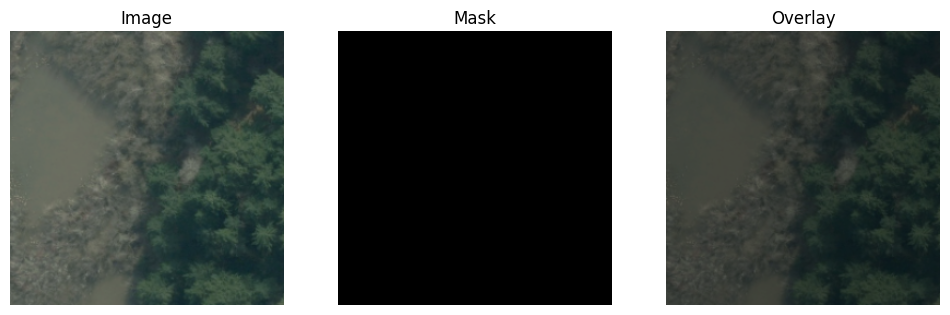

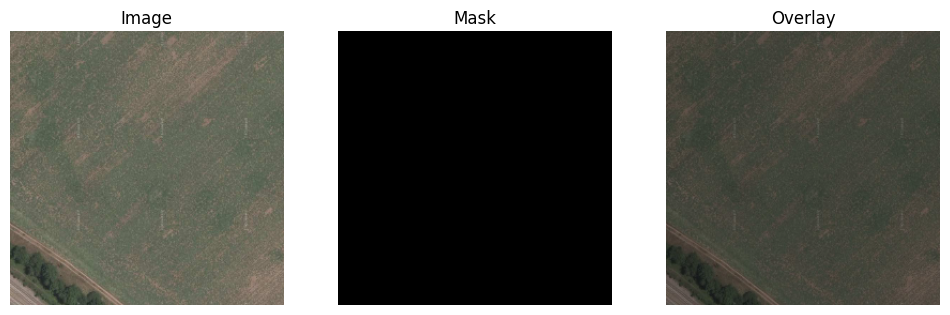

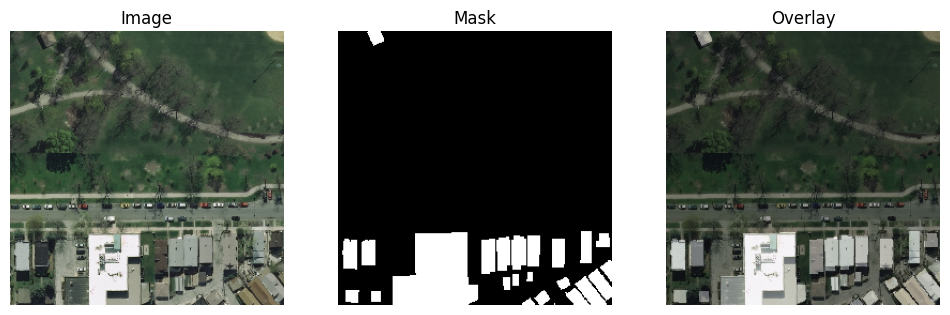

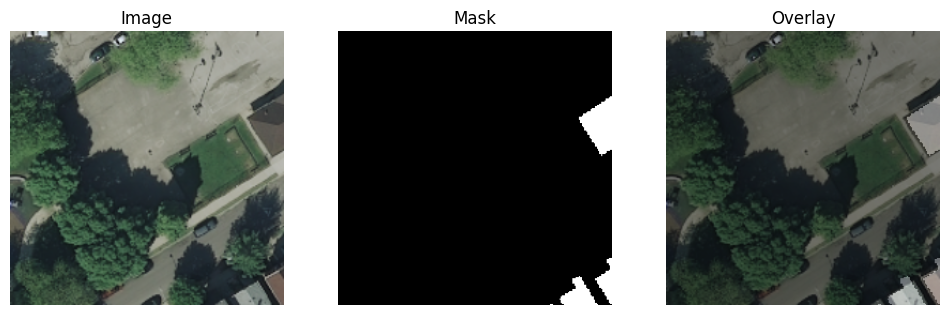

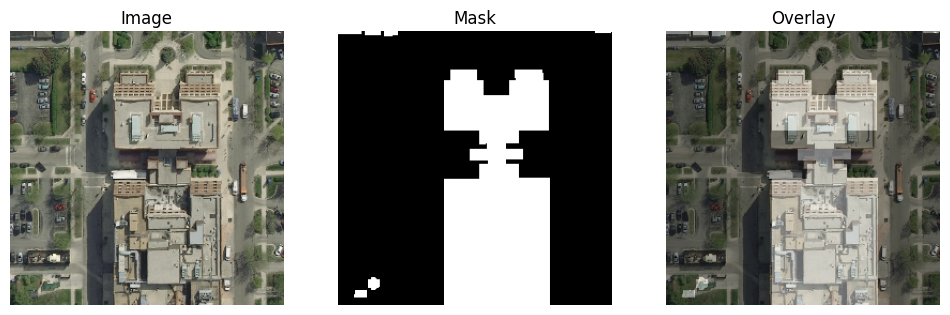

In [6]:
xb, yb = next(iter(train_loader))

n = 5
for i in range(n):
    img = xb[i].permute(1,2,0).cpu().numpy()  # HWC
    msk = yb[i].cpu().numpy().astype(np.uint8)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Image"); plt.imshow(img); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Mask"); plt.imshow(msk, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Overlay")
    plt.imshow(img);
    plt.imshow(msk, alpha=0.35, cmap="gray")  # полупрозрачная маска
    plt.axis("off")
    plt.show()


In [7]:
fracs = []
for _ in range(50):  # 50 батчей
    xb, yb = next(iter(train_loader))
    fracs.append((yb.float().mean(dim=(1,2))).cpu().numpy())
fracs = np.concatenate(fracs)

print("mean building fraction:", fracs.mean())
print("median:", np.median(fracs))
print("min/max:", fracs.min(), fracs.max())
print("empty patches fraction:", (fracs==0).mean())


mean building fraction: 0.16170456
median: 0.08407593
min/max: 0.0 1.0
empty patches fraction: 0.3225


1) Модель + loss (BCE + Dice) + метрики

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# =========================
# U-Net (ResNet50 encoder)
# Возвращает {"out": logits}, чтобы совпасть с твоим текущим training loop.
# =========================

class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, p=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

class UNetDecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.conv1 = ConvBNReLU(in_ch + skip_ch, out_ch)
        self.conv2 = ConvBNReLU(out_ch, out_ch)

    def forward(self, x, skip):
        x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class ResNet50UNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        # weights=None: мы подгрузим веса из твоего best_model.pt (DeepLab) ниже
        self.encoder = resnet50(weights=None)
        self.encoder.fc = nn.Identity()

        # Encoder blocks
        self.enc0 = nn.Sequential(self.encoder.conv1, self.encoder.bn1, self.encoder.relu)  # /2, 64
        self.pool = self.encoder.maxpool                                                  # /4
        self.enc1 = self.encoder.layer1                                                    # /4, 256
        self.enc2 = self.encoder.layer2                                                    # /8, 512
        self.enc3 = self.encoder.layer3                                                    # /16, 1024
        self.enc4 = self.encoder.layer4                                                    # /32, 2048

        # Decoder
        self.dec4 = UNetDecoderBlock(in_ch=2048, skip_ch=1024, out_ch=512)  # /16
        self.dec3 = UNetDecoderBlock(in_ch=512,  skip_ch=512,  out_ch=256)  # /8
        self.dec2 = UNetDecoderBlock(in_ch=256,  skip_ch=256,  out_ch=128)  # /4
        self.dec1 = UNetDecoderBlock(in_ch=128,  skip_ch=64,   out_ch=64)   # /2

        self.head = nn.Sequential(
            ConvBNReLU(64, 32),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x0 = self.enc0(x)             # /2
        x1 = self.enc1(self.pool(x0)) # /4
        x2 = self.enc2(x1)            # /8
        x3 = self.enc3(x2)            # /16
        x4 = self.enc4(x3)            # /32

        d4 = self.dec4(x4, x3)
        d3 = self.dec3(d4, x2)
        d2 = self.dec2(d3, x1)
        d1 = self.dec1(d2, x0)

        out = F.interpolate(d1, size=x.shape[-2:], mode="bilinear", align_corners=False)
        out = self.head(out)          # logits [B,1,H,W]
        return {"out": out}

# --- Model: U-Net, 1 output channel for binary segmentation ---
model = ResNet50UNet(num_classes=1).to(device)

# =========================
# Loss: BCE + Dice (как у тебя было)
# =========================

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, logits, targets):
        # logits: [B,1,H,W], targets: [B,H,W]
        probs = torch.sigmoid(logits).squeeze(1)  # [B,H,W]
        targets = targets.float()

        num = 2.0 * (probs * targets).sum(dim=(1,2))
        den = (probs + targets).sum(dim=(1,2)) + self.eps
        dice = num / den
        return 1 - dice.mean()

# pos_weight ~ (1-p)/p; у тебя mean building ~0.16 => ~5
pos_weight = torch.tensor([5.0], device=device)

bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
dice = DiceLoss()

def loss_fn(logits, targets):
    # logits: [B,1,H,W], targets: [B,H,W]
    return bce(logits, targets.float().unsqueeze(1)) + dice(logits, targets)

@torch.no_grad()
def metrics_from_logits(logits, targets, thr=0.80, eps=1e-6):
    # logits: [B,1,H,W], targets: [B,H,W]
    probs = torch.sigmoid(logits)
    preds = (probs > thr).long().squeeze(1)  # [B,H,W]
    t = targets.long()

    tp = ((preds == 1) & (t == 1)).sum().item()
    fp = ((preds == 1) & (t == 0)).sum().item()
    fn = ((preds == 0) & (t == 1)).sum().item()

    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    iou       = tp / (tp + fp + fn + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)
    return precision, recall, iou, f1


device: cuda


2) Optimizer + AMP + training loop (с grad accumulation)

In [60]:
import math
from torch.cuda.amp import autocast, GradScaler

# Для U-Net с переносом обученного энкодера — разный lr:
# encoder: очень маленький (не “ломаем” признаки), decoder/head: побольше.
encoder_params = list(model.encoder.parameters())
encoder_param_ids = {id(p) for p in encoder_params}
decoder_params = [p for p in model.parameters() if id(p) not in encoder_param_ids]

optimizer = torch.optim.AdamW(
    [
        {"params": encoder_params, "lr": 3e-6}, # после достижения плато снижаем с 1e-5 до 3e-6
        {"params": decoder_params, "lr": 3e-5}, # после достижения плато снижаем с 1e-4 до 3e-5
    ],
    weight_decay=1e-4
)

scaler = GradScaler(enabled=(device.type == "cuda"))

# Настройки:
BATCH = 8          # ставим 8
ACCUM = 4          # эффективный batch = BATCH*ACCUM
EPOCHS = 5
MAX_GRAD_NORM = 1.0

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    total = 0

    optimizer.zero_grad(set_to_none=True)

    for step, (x, y) in enumerate(loader):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with autocast(enabled=(device.type=="cuda")):
            out = model(x)["out"]
            loss = loss_fn(out, y) / ACCUM

        scaler.scale(loss).backward()

        if (step + 1) % ACCUM == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        total_loss += loss.item() * ACCUM
        total += 1

    return total_loss / max(1, total)

@torch.no_grad()
def evaluate(model, loader, max_batches=200):
    model.eval()
    total_loss = 0.0
    P=R=IoU=F1=0.0
    total = 0

    for b, (x, y) in enumerate(loader):
        if max_batches is not None and b >= max_batches:
            break

        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with autocast(enabled=(device.type=="cuda")):
            out = model(x)["out"]
            loss = loss_fn(out, y)

        p, r, iou, f1 = metrics_from_logits(out, y)

        total_loss += loss.item()
        P += p; R += r; IoU += iou; F1 += f1
        total += 1

    if total == 0:
        return 0, 0, 0, 0, 0

    return (total_loss/total, P/total, R/total, IoU/total, F1/total)


/tmp/ipython-input-44463668.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))


3) Подогнать DataLoader под batch

In [61]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=2, pin_memory=True, persistent_workers=True)

val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False,
                        num_workers=2, pin_memory=True, persistent_workers=True)
print(train_loader.batch_size)

8


4) Запуск обучения

In [53]:
best_iou = -1.0
best_epoch = 0

In [ ]:
# =========================
# Загрузка весов и обучение U-Net
# - encoder инициализируем из лучшего DeepLab ResNet checkpoint (best_model.pt)
# - сохраняем отдельные checkpoints для U-Net
# =========================

import os
import torch

DEEPLAB_BEST_PATH = "/content/drive/MyDrive/Models/best_model.pt"    # лучший DeepLab (уже есть) если в коллабе /content/best_model.pt
UNET_BEST_PATH    = "/content/drive/MyDrive/Models/best_unet.pt"     # новый лучший U-Net
UNET_LAST_PATH    = "/content/drive/MyDrive/Models/last_unet.pt"     # новый последний U-Net

def _strip_prefix(state_dict, prefix):
    out = {}
    for k, v in state_dict.items():
        if k.startswith(prefix):
            out[k[len(prefix):]] = v
    return out

def load_unet_encoder_from_deeplab_ckpt(unet_model, ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    sd = ckpt["model_state_dict"] if (isinstance(ckpt, dict) and "model_state_dict" in ckpt) else ckpt

    # на случай DataParallel
    if any(k.startswith("module.") for k in sd.keys()):
        sd = {k.replace("module.", "", 1): v for k, v in sd.items()}

    enc_sd = _strip_prefix(sd, "backbone.")

    # Чтобы fc не мешал (если вдруг есть)
    if hasattr(unet_model.encoder, "fc"):
        unet_model.encoder.fc = nn.Identity()

    missing, unexpected = unet_model.encoder.load_state_dict(enc_sd, strict=False)

    critical_missing = [k for k in missing if k.startswith(("conv1", "bn1", "layer1", "layer2", "layer3", "layer4"))]

    print("✅ Loaded U-Net encoder from DeepLab checkpoint:", ckpt_path)
    print("   extracted encoder keys:", len(enc_sd))
    print("   missing keys:", len(missing), "| unexpected:", len(unexpected))
    print("   critical_missing (should be ~0):", len(critical_missing))
    if critical_missing:
        print("   examples:", critical_missing[:15])

    return ckpt

# --- resume logic ---
start_epoch = 1
best_iou = -1.0

if os.path.exists(UNET_LAST_PATH):
    # продолжаем U-Net (если уже обучал)
    ckpt = torch.load(UNET_LAST_PATH, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    scaler.load_state_dict(ckpt["scaler_state_dict"])
    best_iou = ckpt.get("best_iou", -1.0)
    start_epoch = ckpt["epoch"] + 1
    print(f"✅ Resumed U-Net from {UNET_LAST_PATH} (epoch={ckpt['epoch']}, best_iou={best_iou:.4f})")

else:
    # стартуем новый U-Net: инициализируем encoder из best DeepLab ResNet
    if os.path.exists(DEEPLAB_BEST_PATH):
        _ = load_unet_encoder_from_deeplab_ckpt(model, DEEPLAB_BEST_PATH, device)
    else:
        print("⚠️ DeepLab best_model.pt не найден. U-Net стартует с нуля.")
    print("Starting U-Net training from scratch (decoder/head новые).")

# --- train ---
num_more_epochs = 10

for epoch in range(start_epoch, start_epoch + num_more_epochs):
    tr_loss = train_one_epoch(model, train_loader)
    val_loss, p, r, iou, f1 = evaluate(model, val_loader, max_batches=200)

    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | "
          f"P={p:.3f} R={r:.3f} IoU={iou:.3f} F1={f1:.3f}")

    # best
    if iou > best_iou:
        best_iou = iou
        torch.save({
            "epoch": epoch,
            "best_iou": best_iou,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scaler_state_dict": scaler.state_dict(),
        }, UNET_BEST_PATH)
        print(f"  ✅ Saved BEST U-Net: epoch={epoch}, IoU={best_iou:.4f} -> {UNET_BEST_PATH}")

    # last
    torch.save({
        "epoch": epoch,
        "best_iou": best_iou,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scaler_state_dict": scaler.state_dict(),
    }, UNET_LAST_PATH)


✅ Resumed U-Net from /content/drive/MyDrive/Models/last_unet.pt (epoch=50, best_iou=0.7550)


/tmp/ipython-input-44463668.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=="cuda")):
/tmp/ipython-input-44463668.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=="cuda")):


Epoch 51 | train_loss=0.7126 | val_loss=0.7849 | P=0.863 R=0.844 IoU=0.744 F1=0.851
Epoch 52 | train_loss=0.6855 | val_loss=0.7670 | P=0.828 R=0.891 IoU=0.752 F1=0.856


Проверка

In [55]:
# --- Paths ---
BEST_PATH = "/content/best_unet.pt"
LAST_PATH = "/content/last_unet.pt"

# --- UI state ---
_state = {
    "current_ckpt": None,
    "val_iter": None,
    "thr": 0.8,
    "n": 2,
}

def _load_checkpoint_into_model(which: str):
    assert which in ("best", "last")
    path = BEST_PATH if which == "best" else LAST_PATH
    if not os.path.exists(path):
        raise FileNotFoundError(f"Checkpoint not found: {path}")

    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])

    _state["current_ckpt"] = {
        "which": which,
        "path": path,
        "epoch": ckpt.get("epoch"),
        "best_iou": ckpt.get("best_iou"),
    }

    # reset iterator so "next" starts fresh for the selected checkpoint (optional but nice)
    _state["val_iter"] = iter(val_loader)
    return _state["current_ckpt"]

def _fmt_area_stats(gt_area: int, pr_area: int):
    diff = pr_area - gt_area
    ratio = (pr_area / (gt_area + 1e-6))  # avoid div-by-zero
    return f"GT area={gt_area:,} px | Pred area={pr_area:,} px | Δ={diff:+,} px | Pred/GT={ratio:.3f}"

@torch.no_grad()
def _show_next_batch(n=3, thr=0.80):
    if _state["val_iter"] is None:
        _state["val_iter"] = iter(val_loader)

    try:
        xb, yb = next(_state["val_iter"])
    except StopIteration:
        _state["val_iter"] = iter(val_loader)
        xb, yb = next(_state["val_iter"])

    xb = xb.to(device)
    yb = yb.to(device)

    amp_ctx = cuda_autocast(enabled=(device.type == "cuda")) if device.type == "cuda" else nullcontext()
    with amp_ctx:
        logits = model(xb)["out"]  # [B,1,H,W]
        probs = torch.sigmoid(logits)
        preds = (probs > thr).long().squeeze(1)  # [B,H,W]

    # --- Area stats (BATCH level, on GPU for speed) ---
    gt_area_batch = int((yb == 1).sum().item())
    pr_area_batch = int((preds == 1).sum().item())

    xb = xb.cpu()
    yb = yb.cpu()
    preds = preds.cpu()

    # Header
    ck = _state["current_ckpt"]
    if ck is not None:
        print(f"Checkpoint: {ck['which']} | epoch={ck['epoch']} | best_iou={ck['best_iou']} | thr={thr}")
    else:
        print(f"Checkpoint: (not loaded) | thr={thr}")

    print("Batch totals:", _fmt_area_stats(gt_area_batch, pr_area_batch))
    print("-" * 80)

    for i in range(min(n, xb.shape[0])):
        img = xb[i].permute(1, 2, 0).numpy()
        gt  = yb[i].numpy().astype(np.uint8)
        pr  = preds[i].numpy().astype(np.uint8)

        # --- Area stats (PATCH level) ---
        gt_area = int(gt.sum())
        pr_area = int(pr.sum())

        plt.figure(figsize=(14, 4))
        plt.subplot(1, 4, 1); plt.title("Image"); plt.imshow(img); plt.axis("off")
        plt.subplot(1, 4, 2); plt.title(f"GT | {gt_area:,} px"); plt.imshow(gt, cmap="gray"); plt.axis("off")
        plt.subplot(1, 4, 3); plt.title(f"Pred thr={thr} | {pr_area:,} px"); plt.imshow(pr, cmap="gray"); plt.axis("off")
        plt.subplot(1, 4, 4); plt.title("Overlay"); plt.imshow(img); plt.imshow(pr, cmap="gray", alpha=0.35); plt.axis("off")
        plt.show()

        print(f"Patch {i}: " + _fmt_area_stats(gt_area, pr_area))
    print("=" * 80)

# --- Widgets ---
dd = widgets.Dropdown(
    options=[("best", "best"), ("last", "last")],
    value="best",
    description="Checkpoint:",
    layout=widgets.Layout(width="260px")
)

thr_w = widgets.FloatSlider(
    value=_state["thr"], min=0.3, max=0.9, step=0.05,
    description="thr:", continuous_update=False,
    layout=widgets.Layout(width="380px")
)

btn = widgets.Button(
    description="Показать другие",
    button_style="primary",
    layout=widgets.Layout(width="260px")
)

out = widgets.Output()

def _render_initial():
    out.clear_output(wait=True)
    with out:
        _load_checkpoint_into_model(dd.value)
        _state["thr"] = float(thr_w.value)
        _show_next_batch(n=_state["n"], thr=_state["thr"])

def _on_dd_change(change):
    if change["name"] == "value":
        _render_initial()

def _on_thr_change(change):
    if change["name"] == "value":
        _state["thr"] = float(change["new"])

def _on_btn_click(_):
    out.clear_output(wait=True)
    with out:
        _show_next_batch(n=_state["n"], thr=float(thr_w.value))

dd.observe(_on_dd_change, names="value")
thr_w.observe(_on_thr_change, names="value")
btn.on_click(_on_btn_click)

ui = widgets.HBox([dd, thr_w, btn])
display(ui, out)

# Load default and show first 2
_render_initial()

Output()

In [56]:
# --- choose checkpoint for inference ---

WHICH = "last"  # "best" or "last"
BEST_PATH = "/content/best_unet.pt"
LAST_PATH = "/content/last_unet.pt"

path = BEST_PATH if WHICH == "best" else LAST_PATH
assert os.path.exists(path), f"Missing: {path}"

ckpt = torch.load(path, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()
print(f"Loaded {WHICH}: epoch={ckpt.get('epoch')} best_iou={ckpt.get('best_iou')}")


@torch.no_grad()
def threshold_rescan_for_inference(model, loader, thresholds, max_batches=None):
    """
    Re-scan thresholds by summing TP/FP/FN over pixels.
    max_batches=None -> full val, else fast scan on first N batches.

    Adds: total GT area vs Pred area (pixels) for each threshold.
    """
    acc = {t: {"tp": 0, "fp": 0, "fn": 0, "gt_area": 0, "pred_area": 0} for t in thresholds}

    for i, (x, y) in enumerate(loader):
        if max_batches is not None and i >= max_batches:
            break

        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).long()  # [B,H,W]

        # GT building pixels for this batch (same for all thresholds)
        gt_area_batch = int((y == 1).sum().item())

        with autocast(enabled=(device.type == "cuda")):
            logits = model(x)["out"]  # [B,1,H,W]
        probs = torch.sigmoid(logits)

        for t in thresholds:
            preds = (probs > t).long().squeeze(1)  # [B,H,W]

            tp = ((preds == 1) & (y == 1)).sum().item()
            fp = ((preds == 1) & (y == 0)).sum().item()
            fn = ((preds == 0) & (y == 1)).sum().item()

            pred_area_batch = int((preds == 1).sum().item())

            acc[t]["tp"] += tp
            acc[t]["fp"] += fp
            acc[t]["fn"] += fn
            acc[t]["gt_area"] += gt_area_batch
            acc[t]["pred_area"] += pred_area_batch

    rows = []
    for t in thresholds:
        tp, fp, fn = acc[t]["tp"], acc[t]["fp"], acc[t]["fn"]
        gt_area, pred_area = acc[t]["gt_area"], acc[t]["pred_area"]

        p = tp / (tp + fp + 1e-6)
        r = tp / (tp + fn + 1e-6)
        iou = tp / (tp + fp + fn + 1e-6)
        f1 = 2 * p * r / (p + r + 1e-6)

        area_diff = pred_area - gt_area
        area_ratio = pred_area / (gt_area + 1e-6)

        rows.append((t, p, r, iou, f1, gt_area, pred_area, area_diff, area_ratio))


    rows.sort(key=lambda x: x[3], reverse=True)

    print("thr  |   P     R     IoU     F1   |   GT_area    Pred_area     Δ_area   Pred/GT")
    print("--------------------------------------------------------------------------------")

    for t, p, r, iou, f1, gt_a, pr_a, d_a, rat in rows:
        print(
            f"{t:0.2f} | {p:0.3f} {r:0.3f} {iou:0.4f} {f1:0.4f} | "
            f"{gt_a:10,d} {pr_a:11,d} {d_a:+10,d}   {rat:0.3f}"
        )
    best = rows[0]
    print(
        f"\nBest by IoU: thr={best[0]:0.2f} IoU={best[3]:0.4f} "
        f"(P={best[1]:0.3f}, R={best[2]:0.3f}, F1={best[4]:0.4f}) | "
        f"GT_area={best[5]:,} Pred_area={best[6]:,} Δ={best[7]:+,} Pred/GT={best[8]:0.3f}"
    )
    return best[0], rows

@torch.no_grad()
def dataset_area_comparison(model, loader, thr=0.80, max_batches=None):
    """
    Compare total building area (pixels) on GT vs Pred across the whole val set (or first N batches).
    """
    model.eval()
    gt_total = 0
    pred_total = 0

    for i, (x, y) in enumerate(loader):
        if max_batches is not None and i >= max_batches:
            break

        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).long()

        gt_total += int((y == 1).sum().item())

        with autocast(enabled=(device.type == "cuda")):
            logits = model(x)["out"]
        probs = torch.sigmoid(logits)
        preds = (probs > thr).long().squeeze(1)

        pred_total += int((preds == 1).sum().item())

    diff = pred_total - gt_total
    ratio = pred_total / (gt_total + 1e-6)

    print(f"\nFULL VAL area check @thr={thr:0.2f}")
    print(f"GT total area   : {gt_total:,} px")
    print(f"Pred total area : {pred_total:,} px")
    print(f"Δ (Pred-GT)     : {diff:+,} px")
    print(f"Pred/GT ratio   : {ratio:0.4f}")

    return gt_total, pred_total, diff, ratio


# --- run scan (full val) ---
thresholds = [0.40, 0.50, 0.55, 0.60, 0.65, 0.70, 0.72, 0.75, 0.78, 0.80]
best_thr, table = threshold_rescan_for_inference(model, val_loader, thresholds, max_batches=None)

# --- area comparison across full val for the best threshold ---
_ = dataset_area_comparison(model, val_loader, thr=best_thr, max_batches=None)

Loaded last: epoch=50 best_iou=0.755032276339811


/tmp/ipython-input-1607115299.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


thr  |   P     R     IoU     F1   |   GT_area    Pred_area     Δ_area   Pred/GT
--------------------------------------------------------------------------------
0.80 | 0.842 0.870 0.7483 0.8560 | 14,308,413  14,776,312   +467,899   1.033
0.78 | 0.836 0.875 0.7474 0.8554 | 14,308,413  14,972,937   +664,524   1.046
0.75 | 0.828 0.882 0.7457 0.8543 | 14,308,413  15,242,177   +933,764   1.065
0.72 | 0.820 0.888 0.7435 0.8529 | 14,308,413  15,490,465 +1,182,052   1.083
0.70 | 0.815 0.892 0.7419 0.8518 | 14,308,413  15,649,623 +1,341,210   1.094
0.65 | 0.803 0.900 0.7371 0.8487 | 14,308,413  16,033,525 +1,725,112   1.121
0.60 | 0.791 0.907 0.7313 0.8448 | 14,308,413  16,405,506 +2,097,093   1.147
0.55 | 0.779 0.913 0.7249 0.8405 | 14,308,413  16,775,135 +2,466,722   1.172
0.50 | 0.766 0.919 0.7175 0.8355 | 14,308,413  17,160,736 +2,852,323   1.199
0.40 | 0.738 0.930 0.6998 0.8234 | 14,308,413  18,028,111 +3,719,698   1.260

Best by IoU: thr=0.80 IoU=0.7483 (P=0.842, R=0.870, F1=0.8560) | GT_

/tmp/ipython-input-1607115299.py:107: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):



FULL VAL area check @thr=0.80
GT total area   : 15,109,072 px
Pred total area : 15,970,153 px
Δ (Pred-GT)     : +861,081 px
Pred/GT ratio   : 1.0570
